In [1]:
bimport sys
sys.path.insert(1,'E:\DUY\DS\deeplearning\CustomTools')
import ultility_tools as utt

from sklearn.datasets import fetch_lfw_people
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 1/ Loading data

In [2]:
data = fetch_lfw_people(min_faces_per_person=70,resize=0.4)

In [3]:
data

{'data': array([[254.      , 254.      , 251.66667 , ...,  87.333336,  88.666664,
          86.666664],
        [ 39.666668,  50.333332,  47.      , ..., 117.666664, 115.      ,
         133.66667 ],
        [ 89.333336, 104.      , 126.      , ..., 175.33333 , 183.33333 ,
         183.      ],
        ...,
        [ 86.      ,  80.333336,  74.666664, ...,  44.      ,  49.666668,
          44.666668],
        [ 50.333332,  65.666664,  88.      , ..., 197.      , 179.33333 ,
         166.33333 ],
        [ 30.      ,  27.      ,  32.666668, ...,  35.      ,  35.333332,
          61.      ]], dtype=float32),
 'images': array([[[254.      , 254.      , 251.66667 , ...,  65.333336,
           50.666668,  40.333332],
         [253.33333 , 251.33333 , 247.33333 , ...,  66.666664,
           52.      ,  42.666668],
         [240.66667 , 231.66667 , 211.66667 , ...,  62.      ,
           49.      ,  42.      ],
         ...,
         [ 74.333336,  54.      ,  31.666666, ...,  97.666664,
     

# 2/ Exploring data

In [4]:
# create feature and response sets
X = data.data
y = data.target
print(X.shape)
print(y.shape)


(1288, 1850)
(1288,)


In [5]:
# count unique elements and their frequency in the response setc
print(Counter(y).keys())
print(Counter(y).values())

dict_keys([5, 6, 3, 1, 0, 4, 2])
dict_values([71, 144, 530, 236, 77, 109, 121])


In [6]:
# get info of images
print(data.images.shape)

# get names of people in the images
print(data.target_names)

(1288, 50, 37)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


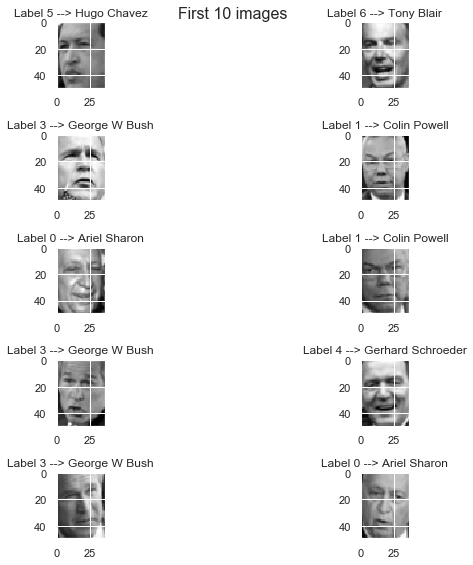

In [7]:
# display the fist 10 images from the feature set and the label from the response set
n =10
plt.figure(figsize=(10, 8))
for i in range(n):
    plt.subplot(n/2, 2, i + 1)
    plt.imshow(X[i].reshape((50, 37)),cmap=plt.cm.gray)
    plt.title(f"Label {y[i]} --> {data.target_names[y[i]]}")
plt.suptitle(f'First {n} images', fontsize=16)
plt.tight_layout()
plt.show()


# 3/ Splitting data

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=40)
print(X_train.shape)
print(X.shape)

(966, 1850)
(1288, 1850)


# 4/ Building Models

## 4.1/ Selecting Baseline model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

models ={"model_name": ["Logistic Regression",
                        "Native Bayes"],
         "model_command": [LogisticRegression(),
                           GaussianNB()],
         "model_params": [{'C':[1e-1, 1e0, 1e1, 1e2], 'penalty':['l1', 'l2']},
                          {}]
         }

best_grid, df_models_results = utt.get_all_best_models(models, X_train, y_train)
df_models_results

,model_name,best_score,best_params,fit_time,score_time
0,Logistic Regression,0.815768,"{'C': 10.0, 'penalty': 'l2'}",0.123618,0.000997
1,Native Bayes,0.449308,{},0.014760,0.031316


### - Testing the best base classifier on the test-set

In [10]:
from sklearn.metrics import accuracy_score
selected_model= best_grid.best_estimator_
y_predict =selected_model.predict(X_test)
print(accuracy_score(y_predict,y_test))


0.7732919254658385


## 4.2/ Pipeline: Estimator = StandardScaler + PCA + LogisticRegression

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe1 = Pipeline([("scaler",StandardScaler()),
                  ("pca",PCA()),
                  ("classifier",LogisticRegression(C=10.0))])

pipe1_params = {"scaler__with_std":[True,False],
                "pca__n_components":[10,50,100,200,250,300, None]}

grid1 = utt.get_best_for_model(pipe1,pipe1_params,X_train,y_train)

************************************************
Best Accuracy: 0.8447411997222372
Best Parameters: {'pca__n_components': None, 'scaler__with_std': True}
Average Time to Fit: 0.135 (s)
Average Time to Score: 0.004 (s)
************************************************


### - Testing the selected estimator on the test-set

In [12]:
selected_model= grid1.best_estimator_
y_predict =selected_model.predict(X_test)
print(accuracy_score(y_predict,y_test))

0.84472049689441


In [13]:
print(classification_report(y_test,y_predict,target_names=data.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.65      0.73        23
     Colin Powell       0.81      0.85      0.83        60
  Donald Rumsfeld       0.74      0.81      0.78        32
    George W Bush       0.88      0.93      0.90       121
Gerhard Schroeder       0.85      0.71      0.77        24
      Hugo Chavez       0.93      0.87      0.90        15
       Tony Blair       0.86      0.81      0.84        47

         accuracy                           0.84       322
        macro avg       0.84      0.80      0.82       322
     weighted avg       0.85      0.84      0.84       322



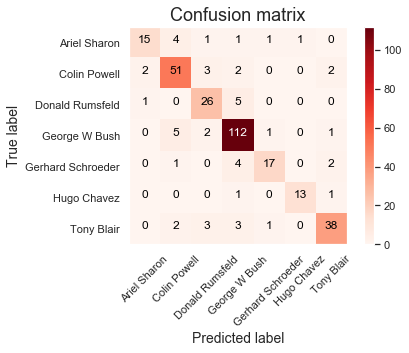

In [14]:
cmm = utt.get_confusion_matrix(y_test, y_predict, data.target_names)

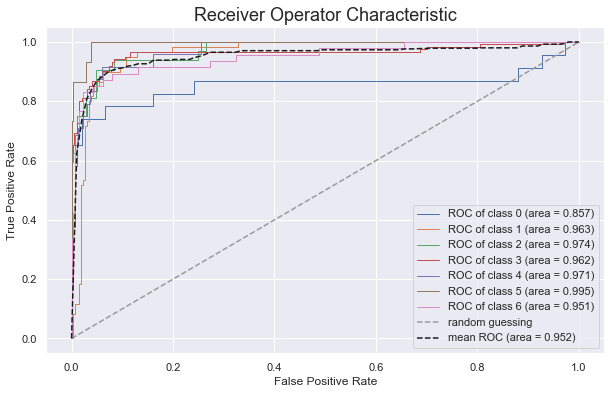

In [15]:
utt.get_roc(selected_model,X_test,y_test)



# 4/ Convolution Neural Networks

In [21]:
# normalize (rescale) data
X_train = X_train/255.
X_test = X_test/255.

In [82]:
# reshape data
X_train_reshape = X_train.reshape((len(X_train),50, 37,1))
X_test_reshape = X_test.reshape((len(X_test),50, 37,1))

print("X_train_reshape = ",X_train_reshape.shape)
print("X_test_reshape = ",X_test_reshape.shape)

X_train_reshape =  (966, 50, 37, 1)
X_test_reshape =  (322, 50, 37, 1)


In [117]:
from tensorflow import keras as ks
cnn = ks.models.Sequential()
cnn.add(ks.layers.Conv2D(8,(15,2),activation='relu',input_shape=(50,37,1),name="Conv2D_layer_1"))
cnn.add(ks.layers.MaxPool2D((2,2),strides=2,name="MaxPool2D_layer_1"))
cnn.add(ks.layers.Conv2D(16,(5,5),activation='relu',name="Conv2D_layer_2"))
cnn.add(ks.layers.MaxPool2D((2,2),strides=2,name="MaxPool2D_layer_2"))
cnn.add(ks.layers.Flatten(name="Flatten"))
cnn.add(ks.layers.Dense(300,activation='relu',name="Hidden_layer_2"))
cnn.add(ks.layers.Dense(50,activation='relu',name="Hidden_layer_3"))
cnn.add(ks.layers.Dense(len(data.target_names),activation="softmax",name="Output_layer"))
cnn.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_layer_1 (Conv2D)      (None, 36, 36, 8)         248       
_________________________________________________________________
MaxPool2D_layer_1 (MaxPoolin (None, 18, 18, 8)         0         
_________________________________________________________________
Conv2D_layer_2 (Conv2D)      (None, 14, 14, 16)        3216      
_________________________________________________________________
MaxPool2D_layer_2 (MaxPoolin (None, 7, 7, 16)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 300)               235500    
_________________________________________________________________
Hidden_layer_3 (Dense)       (None, 50)              

In [118]:
cnn.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [119]:
cnn.fit(X_train_reshape,y_train,epochs=20)


Epoch 1/20
966/966 [==============================] - 1s 592us/sample - loss: 1.6990 - acc: 0.4120
Epoch 2/20
966/966 [==============================] - 0s 328us/sample - loss: 1.6270 - acc: 0.4234

### - Training Evaluation

In [120]:
training_loss, training_accuracy = cnn.evaluate(X_train_reshape,y_train)
print("training_accuracy = ", training_accuracy)
print("training_loss = ", training_loss)

966/966 [==============================] - 0s 190us/sample - loss: 0.1406 - acc: 0.9513
training_accuracy =  0.95134574
training_loss =  0.14056379361922697


### - Testing Evaluation

In [121]:
test_loss, test_accuracy = cnn.evaluate(X_test_reshape,y_test)
print("test_accuracy = ", test_accuracy)
print("test_loss = ", test_loss)


322/322 [==============================] - 0s 147us/sample - loss: 0.8543 - acc: 0.7764
test_accuracy =  0.7763975
test_loss =  0.8542880521547078


# 5/ Deep Neural Networks

In [64]:
# reshape data
X_train_reshape = X_train.reshape((len(X_train),50, 37))
X_test_reshape = X_test.reshape((len(X_test),50, 37))

print("X_train_reshape = ",X_train_reshape.shape)
print("X_test_reshape = ",X_test_reshape.shape)

X_train_reshape =  (966, 50, 37)
X_test_reshape =  (322, 50, 37)


In [65]:
from tensorflow import keras as ks
cnn = ks.models.Sequential()
cnn.add(ks.layers.Flatten(input_shape=[50, 37],name="Input_layer"))
cnn.add(ks.layers.Dense(300,activation='relu',name="Hidden_layer_1"))
cnn.add(ks.layers.Dense(100,activation='relu',name="Hidden_layer_2"))
cnn.add(ks.layers.Dense(50,activation='relu',name="Hidden_layer_3"))
cnn.add(ks.layers.Dense(len(data.target_names),activation="softmax",name="Output_layer"))
cnn.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 1850)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 300)               555300    
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 100)               30100     
_________________________________________________________________
Hidden_layer_3 (Dense)       (None, 50)                5050      
_________________________________________________________________
Output_layer (Dense)         (None, 7)                 357       
Total params: 590,807
Trainable params: 590,807
Non-trainable params: 0
_________________________________________________________________


In [66]:
cnn.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [72]:
cnn.fit(X_train_reshape,y_train,epochs=30)


Epoch 1/30
966/966 [==============================] - 0s 98us/sample - loss: 0.5584 - acc: 0.8147
Epoch 2/30
966/966 [==============================] - 0s 77us/sample - loss: 0.5651 - acc: 0.8095
Epoch 3/30
966/966 [==============================] - 0s 74us/sample - loss: 0.5808 - acc: 0.7878
Epoch 4/30
966/966 [==============================] - 0s 151us/sample - loss: 0.6306 - acc: 0.7857

### - Training Evaluation

In [73]:
training_loss, training_accuracy = cnn.evaluate(X_train_reshape,y_train)
print("training_accuracy = ", training_accuracy)
print("training_loss = ", training_loss)

966/966 [==============================] - 0s 33us/sample - loss: 0.2136 - acc: 0.9358
training_accuracy =  0.9358178
training_loss =  0.2135728173127579


### - Testing Evaluation

In [74]:
test_loss, test_accuracy = cnn.evaluate(X_test_reshape,y_test)
print("test_accuracbby = ", test_accuracy)
print("test_loss = ", test_loss)

322/322 [==============================] - 0s 34us/sample - loss: 0.7241 - acc: 0.7888
test_accuracbby =  0.78881985
test_loss =  0.7241400887507089


In [75]:
len(X_train)

966